In [2]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import pandas as pd

In [3]:
def loss_fun(gt, pred):
    return ((gt-pred)**2).mean()
    

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S = y
        ds = self.theta[0]*S**2 - self.theta[1]*S**3
        return ds

def gt_fun(t, y):
    theta_0 = 1.0
    theta_1 = 2.0
    S = y
    ds = theta_0*S**2 - theta_1*S**3
    return ds
        
true_y0 = torch.tensor([0.5])
t = torch.linspace(0, 5, 100) 


# gt
with torch.no_grad():
    true_y = odeint(gt_fun, true_y0, t, method='dopri5')
    true_y_noise = true_y + torch.randn(true_y.shape)*0.02
    #true_y_adj = odeint_adjoint(gt_fun, true_y0, t, method='dopri5')


func = ODEFun()
lr = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=lr)

losses = []
print('itr loss theta_0 theta_1')
for ii in range(num_iters): 
    
    optimizer.zero_grad()
    
    #pred = odeint(func, true_y0, t, method='dopri5')
    pred = odeint_adjoint(func, true_y0, t, method='dopri5')
    loss = loss_fun(true_y_noise, pred)
    
    loss.backward()
    optimizer.step()
    
    if ii % 10 == 0:
        print(ii, round(loss.item(), 4), round(func.theta[0].item(), 4), round(func.theta[1].item(), 4))
        losses.append(loss.item())

# Note: here the GT values are hardcoded - fix
print('\n')
print('GT  : theta_0: {:2.2}, theta_1: {:2.2}'.format(1.0, 2.0))
print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.theta[0].item(), 4), round(func.theta[1].item(), 4)))

plt.figure(1)
with torch.no_grad():
    plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')
    plt.plot(t, pred[:,0], 'k', lw=1, label='S Pred')
plt.legend()
plt.xlabel('time')
plt.show()

itr loss theta_0 theta_1
0 0.0004 -0.1 0.1
10 0.0005 -0.0143 0.0167
20 0.0004 -0.0049 0.0092
30 0.0004 -0.0017 0.006


KeyboardInterrupt: 

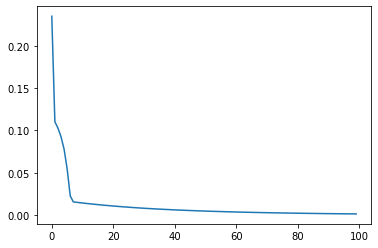

In [43]:
plt.plot(losses)
plt.yscale('log')

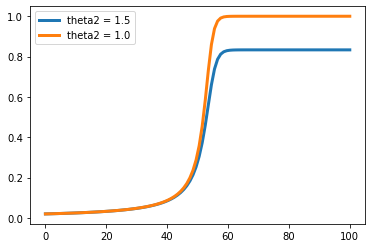

In [26]:
def gt_fun(t, y):
    theta_0 = 1.0
    theta_1 = 1.2
    S = y
    ds = theta_0*S**2 - theta_1*S**3
    return ds

def gt_fun2(t, y):
    theta_0 = 1.0
    theta_1 = 1.0
    S = y
    ds = theta_0*S**2 - theta_1*S**3
    return ds

delta = 0.02
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 

true_y = odeint(gt_fun, y0, t, method='dopri5')
true_y2 = odeint(gt_fun2, y0, t, method='dopri5')

plt.plot(t, true_y[:,0], lw=3, label='theta2 = 1.5')
plt.plot(t, true_y2[:,0], lw=3, label='theta2 = 1.0')
plt.legend()